In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sales_processing import fill_in_dates
from pandas.plotting import lag_plot

In [2]:
sales = pd.read_csv('data/caspecoTrainingData.csv')

dates = pd.date_range('2020-01-01', '2023-01-04')

sales = fill_in_dates(sales, dates)

#divide sales into Company
sales_company_1 = sales[sales['Company'] == 0]
sales_company_2 = sales[sales['Company'] == 1]
sales_company_3 = sales[sales['Company'] == 2]

sales_company_1.index = pd.DatetimeIndex(sales_company_1['Date'], freq='D')
sales_company_2.index = pd.DatetimeIndex(sales_company_2['Date'], freq='D')
sales_company_3.index = pd.DatetimeIndex(sales_company_3['Date'], freq='D')

sales_company_1 = sales_company_1.drop(columns=['Company', 'Date'])
sales_company_2 = sales_company_2.drop(columns=['Company', 'Date'])
sales_company_3 = sales_company_3.drop(columns=['Company', 'Date'])



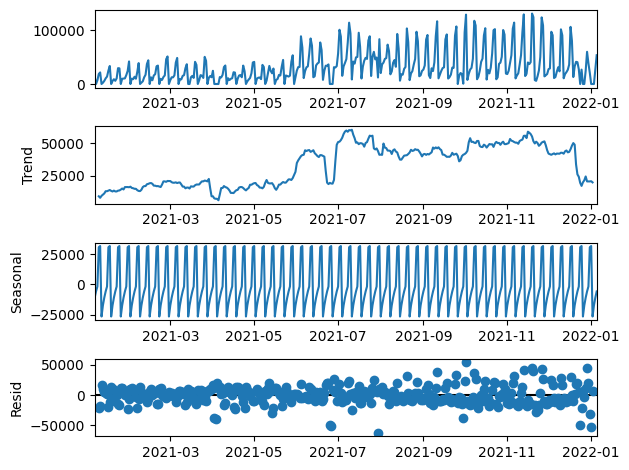

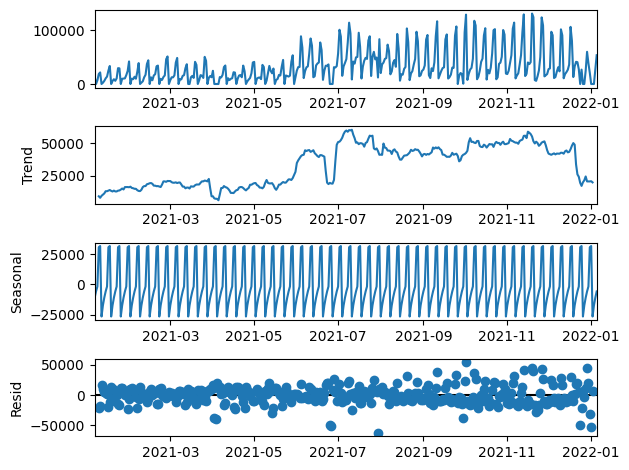

In [3]:
## CODE FROM https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_data_c1 = seasonal_decompose(sales_company_1['2021-01-05':'2022-01-05'], model="additive")
decompose_data_c1.plot()


<AxesSubplot: xlabel='Date'>

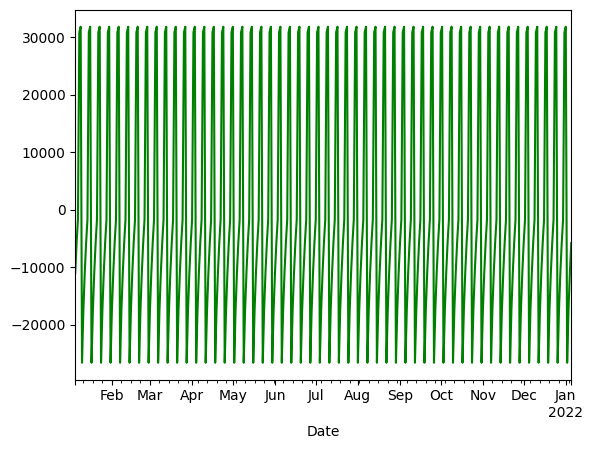

In [4]:

seasonality=decompose_data_c1.seasonal
seasonality.plot(color='green')

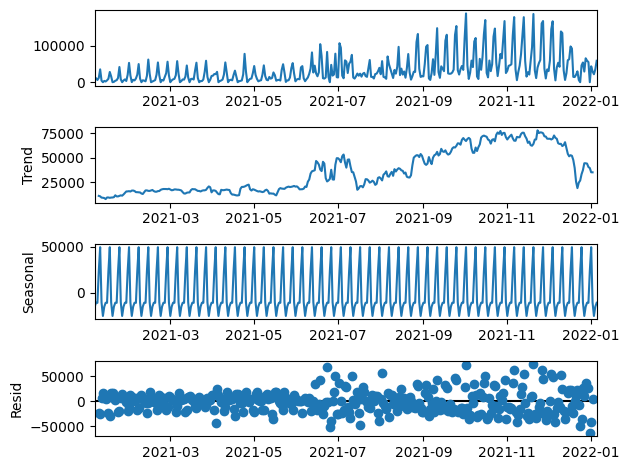

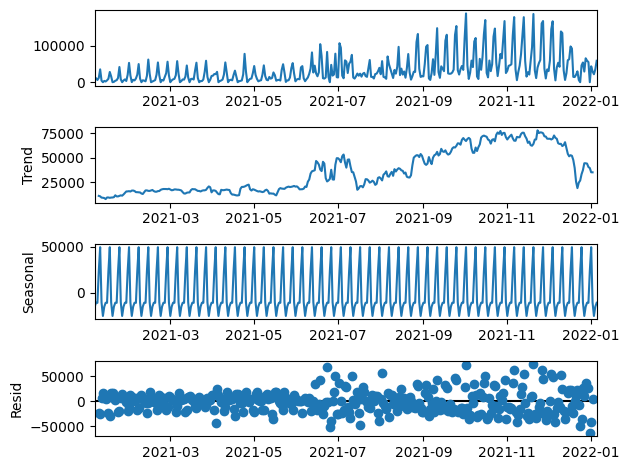

In [5]:

decompose_data_c2 = seasonal_decompose(sales_company_2['2021-01-05':'2022-01-05'], model="additive")
decompose_data_c2.plot()


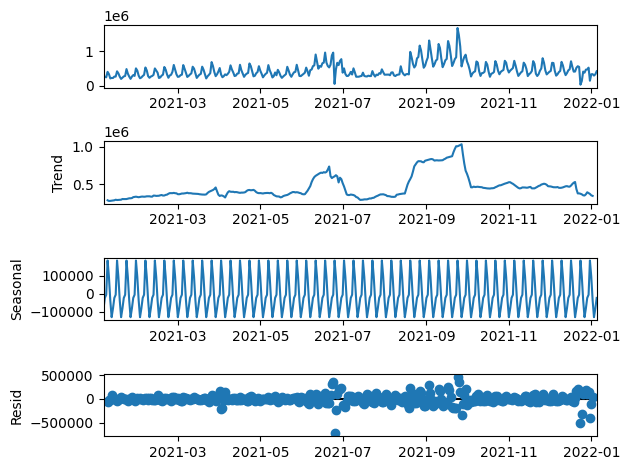

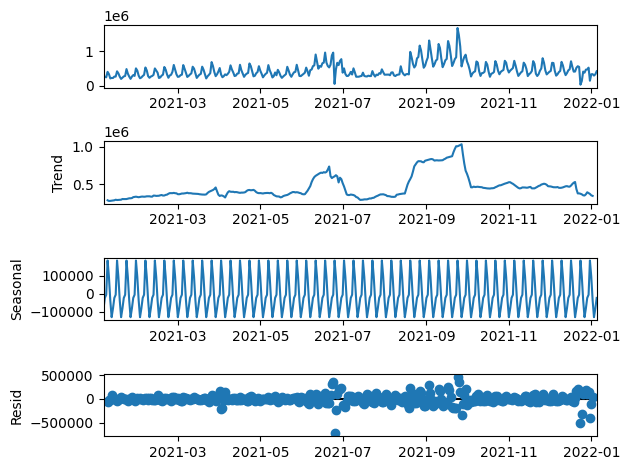

In [6]:

decompose_data_c3 = seasonal_decompose(sales_company_3['2021-01-05':'2022-01-05'], model="additive")
decompose_data_c3.plot()



In [7]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(sales_company_3, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.00016353787492
2. P-Value :  0.03487913071765408
3. Num Of Lags :  22
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1077
5. Critical Values :
	 1% :  -3.436436308605049
	 5% :  -2.8642273405849363
	 10% :  -2.568200833956216


<AxesSubplot: title={'center': 'original'}, xlabel='Date'>

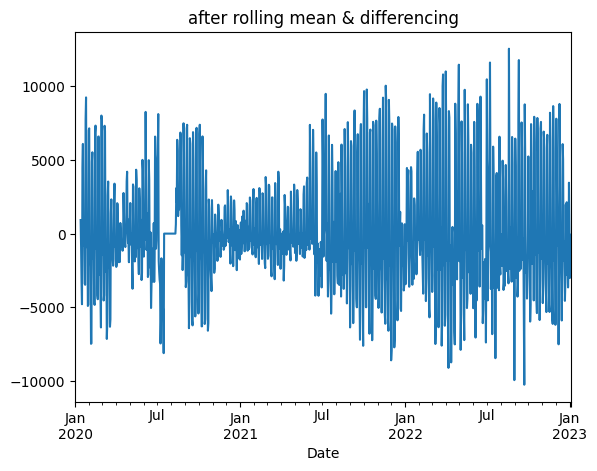

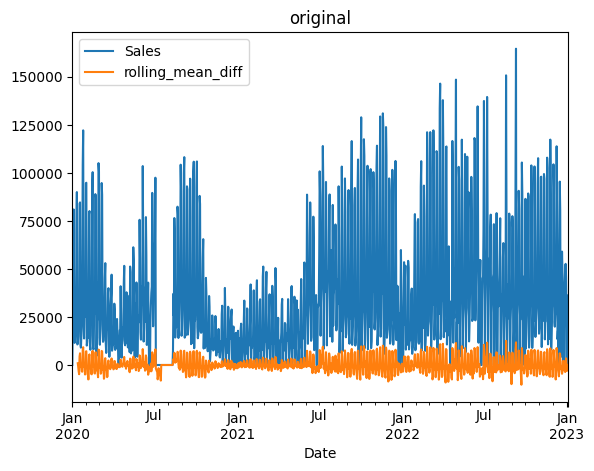

In [8]:
rolling_mean = sales_company_1.rolling(window = 12).mean()
sales_company_1['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
sales_company_1['rolling_mean_diff'].plot(title='after rolling mean & differencing')
ax2 = plt.subplot()
sales_company_1.plot(title='original')

In [9]:
dftest = adfuller(sales_company_1['rolling_mean_diff'].dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
  print("\t",key, ": ", val)

1. ADF :  -6.417404936456145
2. P-Value :  1.8267796476736192e-08
3. Num Of Lags :  22
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1065
5. Critical Values :
	 1% :  -3.4365050530846846
	 5% :  -2.864257662806096
	 10% :  -2.568216983623179


C:\Users\annah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\annah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\annah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot: xlabel='Date'>

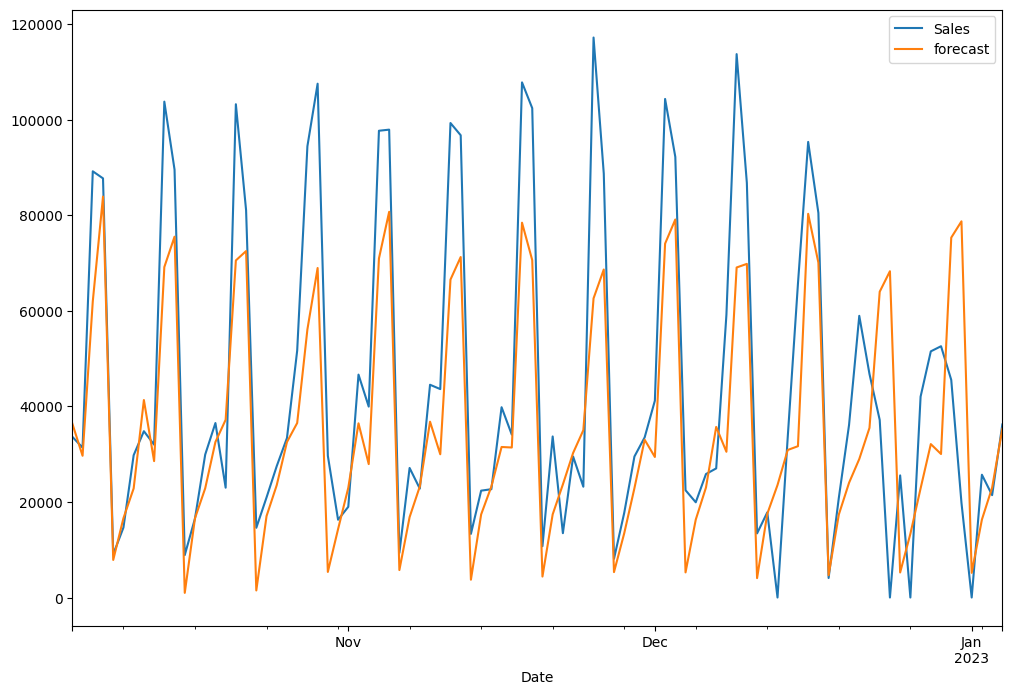

In [10]:
import statsmodels.api as sm

model=sm.tsa.statespace.SARIMAX(sales_company_1['Sales'],order=(21, 1, 8),seasonal_order=(1,1,1,28))
results=model.fit()
start = pd.to_datetime('2023-01-04')
end = pd.to_datetime('2023-01-19')
start_act = pd.to_datetime('2022-10-05')
end_act = pd.to_datetime('2023-01-19')
sales_company_1['forecast']=results.predict(start=start_act,end=end_act,dynamic=True)
sales_company_1[['Sales','forecast']][start_act:end_act].plot(figsize=(12,8))


                   Sales  rolling_mean_diff     forecast
Date                                                    
2023-01-04  36221.562895         -78.619014  35297.25605


<AxesSubplot: >

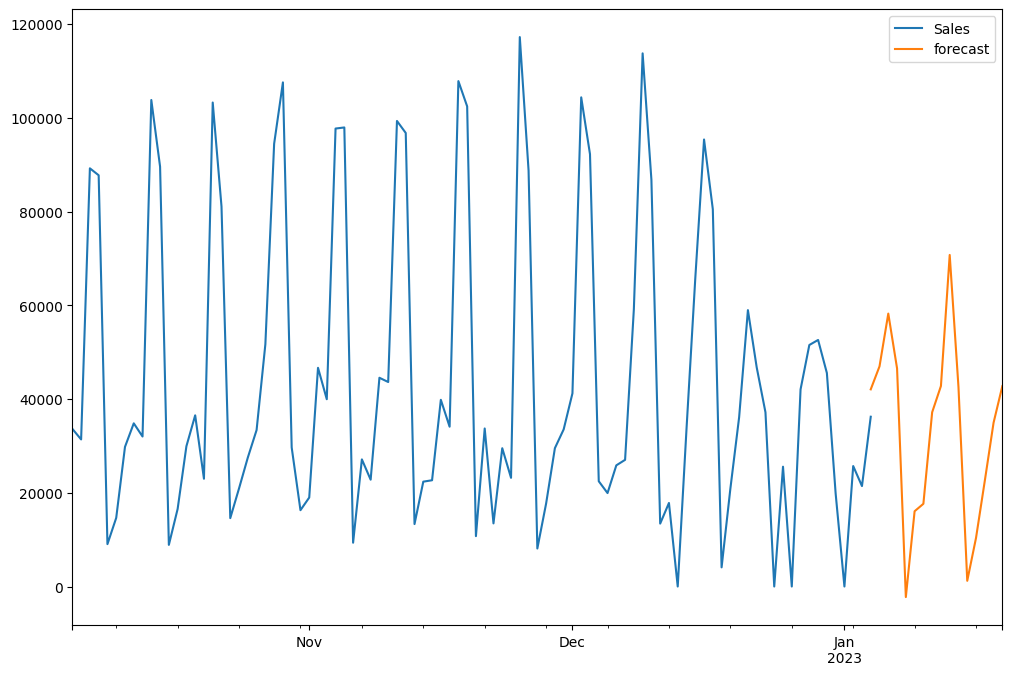

In [11]:
from pandas.tseries.offsets import DateOffset
print(sales_company_1[-1:])

pred_date=[sales_company_1.index[-1]+ DateOffset(days=x)for x in range(0,16)]
pred_date=pd.DataFrame(index=pred_date[1:],columns=sales_company_1.columns)
sales_company_1=pd.concat([sales_company_1,pred_date])
sales_company_1['forecast'] = results.predict(start = start, end = end, dynamic= True)  
sales_company_1[['Sales', 'forecast']][start_act:end_act].plot(figsize=(12, 8))

C:\Users\annah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\annah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\annah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot: xlabel='Date'>

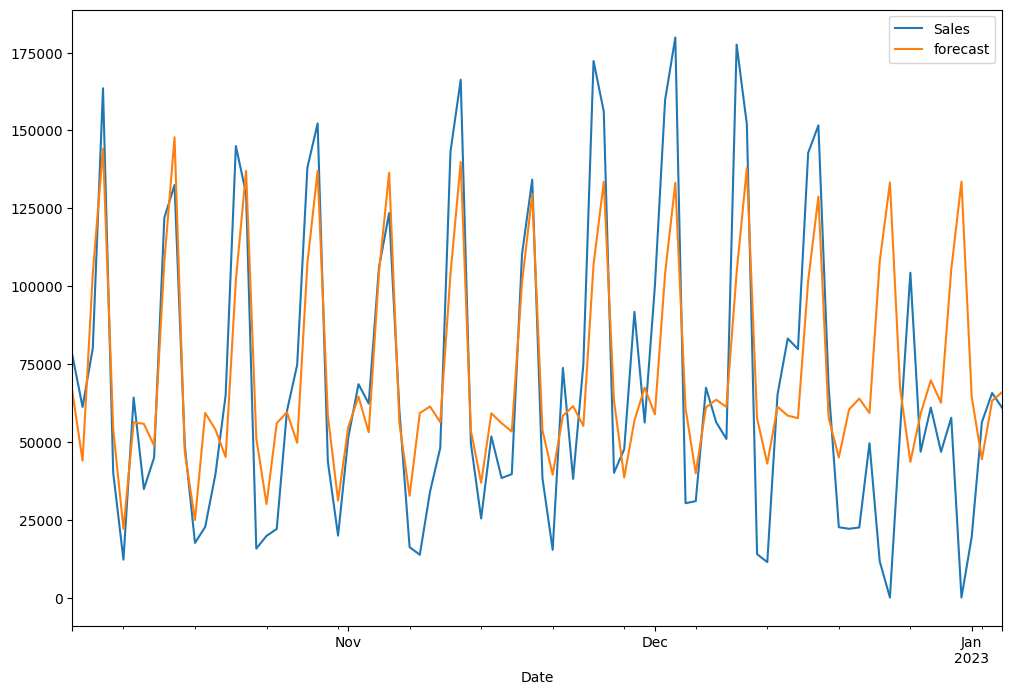

In [12]:
model=sm.tsa.statespace.SARIMAX(sales_company_2['Sales'],order=(21, 1, 8),seasonal_order=(1,1,1,28))
results=model.fit()
start = pd.to_datetime('2023-01-04')
end = pd.to_datetime('2023-01-19')
start_act = pd.to_datetime('2022-10-05')
end_act = pd.to_datetime('2023-01-19')
sales_company_2['forecast']=results.predict(start=start_act,end=end_act,dynamic=True)
sales_company_2[['Sales','forecast']][start_act:end_act].plot(figsize=(12,8))


<AxesSubplot: >

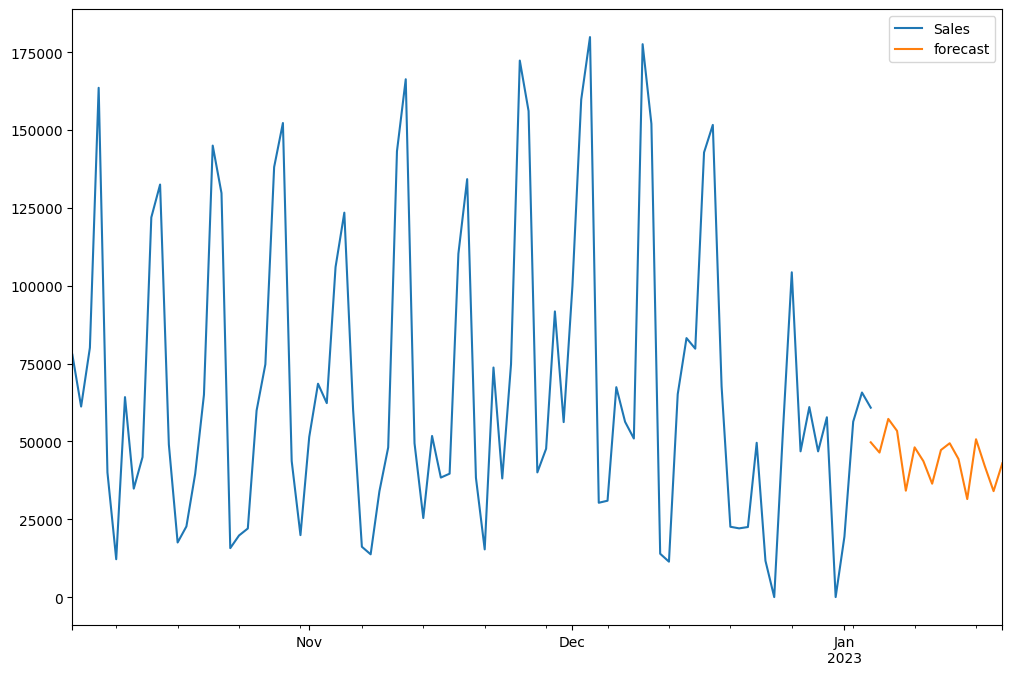

In [13]:
from pandas.tseries.offsets import DateOffset
pred_date=[sales_company_2.index[-1]+ DateOffset(days=x)for x in range(0,16)]

pred_date=pd.DataFrame(index=pred_date[1:],columns=sales_company_2.columns)
sales_company_2=pd.concat([sales_company_2,pred_date])
sales_company_2['forecast'] = results.predict(start = start, end = end, dynamic= True)  
sales_company_2[['Sales', 'forecast']][start_act:end_act].plot(figsize=(12, 8))

C:\Users\annah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\annah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\annah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot: xlabel='Date'>

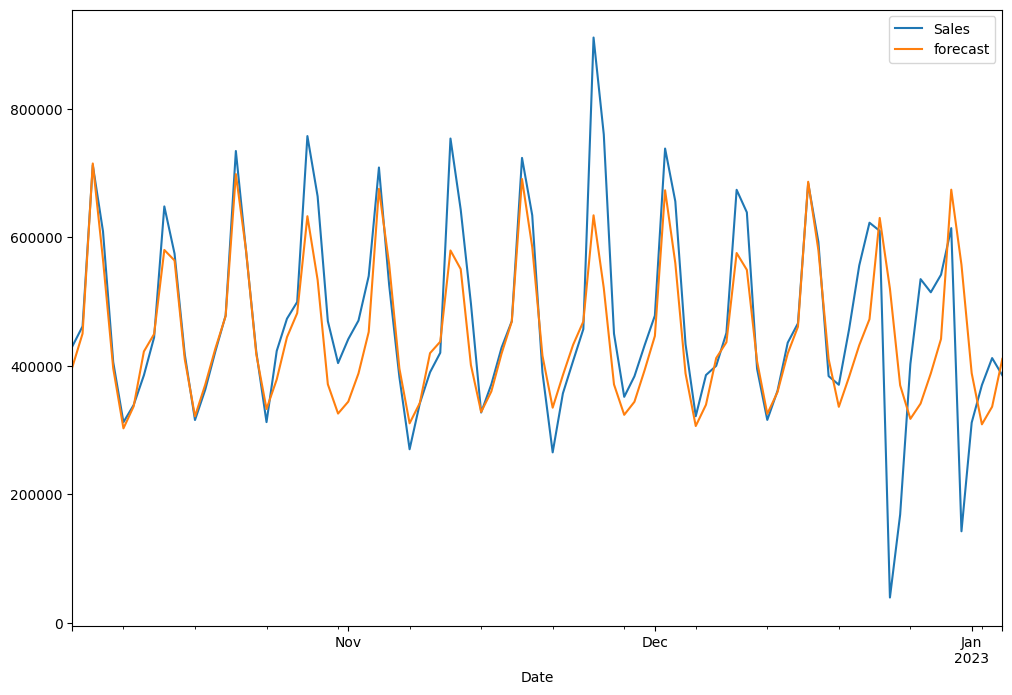

In [14]:
model=sm.tsa.statespace.SARIMAX(sales_company_3['Sales'],order=(21, 1, 8),seasonal_order=(1,1,1,28))
results=model.fit()
start = pd.to_datetime('2023-01-04')
end = pd.to_datetime('2023-01-19')
start_act = pd.to_datetime('2022-10-05')
end_act = pd.to_datetime('2023-01-19')
sales_company_3['forecast']=results.predict(start=start_act,end=end_act,dynamic=True)
sales_company_3[['Sales','forecast']][start_act:end_act].plot(figsize=(12,8))


<AxesSubplot: >

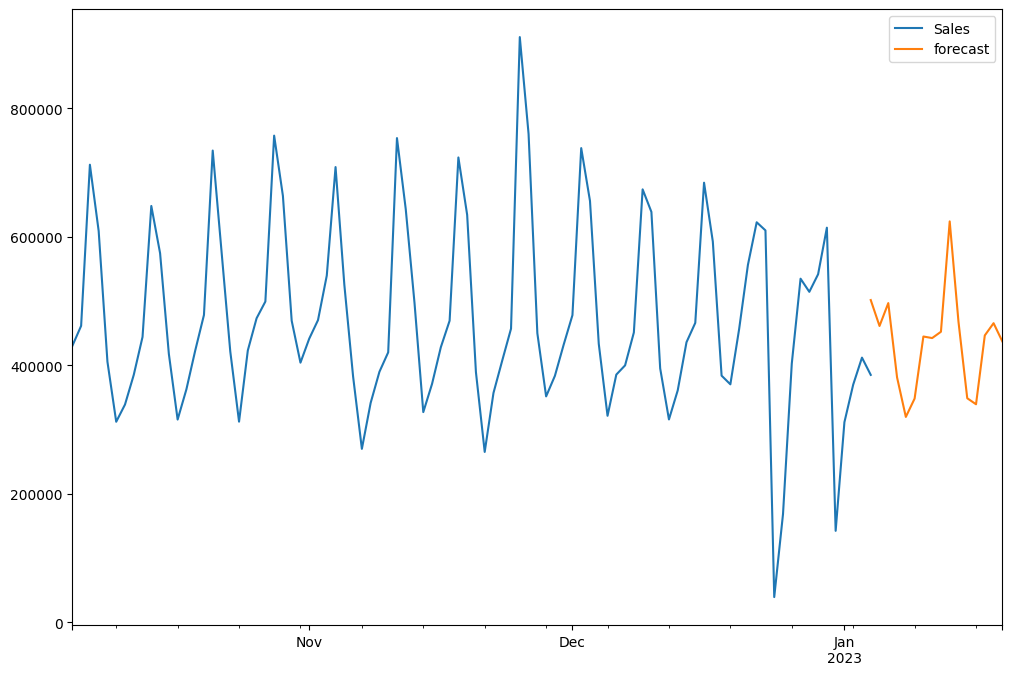

In [15]:
from pandas.tseries.offsets import DateOffset
pred_date=[sales_company_3.index[-1]+ DateOffset(days=x)for x in range(0,16)]

pred_date=pd.DataFrame(index=pred_date[1:],columns=sales_company_3.columns)
sales_company_3=pd.concat([sales_company_3,pred_date])
sales_company_3['forecast'] = results.predict(start = start, end = end, dynamic= True)  
sales_company_3[['Sales', 'forecast']][start_act:end_act].plot(figsize=(12, 8))

In [16]:
companies = [sales_company_1, sales_company_2, sales_company_3]
handin_1 = pd.DataFrame({'ID': sales_company_1.index.astype(str) + '_' + str(0) , 'Sales': sales_company_1['forecast']})
handin_2 = pd.DataFrame({'ID': sales_company_2.index.astype(str) + '_' + str(1) , 'Sales': sales_company_2['forecast']})
handin_3 = pd.DataFrame({'ID': sales_company_3.index.astype(str) + '_' + str(2) , 'Sales': sales_company_3['forecast']})
handin = pd.concat([handin_1, handin_2, handin_3])
handin.dropna(inplace=True)
handin.drop(index='2023-01-04', inplace=True)
handin['Sales'] = handin['Sales'].map(lambda x: 0 if x< 0 else x)
print(handin)
handin.to_csv('handin.csv', index=False)

                      ID          Sales
2023-01-05  2023-01-05_0   46970.223493
2023-01-06  2023-01-06_0   58218.610430
2023-01-07  2023-01-07_0   46528.160580
2023-01-08  2023-01-08_0       0.000000
2023-01-09  2023-01-09_0   16061.319532
2023-01-10  2023-01-10_0   17645.628180
2023-01-11  2023-01-11_0   37174.579804
2023-01-12  2023-01-12_0   42773.219658
2023-01-13  2023-01-13_0   70733.170273
2023-01-14  2023-01-14_0   42539.389018
2023-01-15  2023-01-15_0    1220.808382
2023-01-16  2023-01-16_0   10376.809613
2023-01-17  2023-01-17_0   22546.561009
2023-01-18  2023-01-18_0   34950.024071
2023-01-19  2023-01-19_0   42754.447147
2023-01-05  2023-01-05_1   46402.290785
2023-01-06  2023-01-06_1   57213.779600
2023-01-07  2023-01-07_1   53363.515148
2023-01-08  2023-01-08_1   34158.809445
2023-01-09  2023-01-09_1   48081.518332
2023-01-10  2023-01-10_1   43648.728677
2023-01-11  2023-01-11_1   36408.853778
2023-01-12  2023-01-12_1   47221.602448
2023-01-13  2023-01-13_1   49398.392479
